In this notebook we are  using Mobilenet to classify images of xray images of chest on detecting pneunomia.
The source paper for Mobilenet is located here: https://arxiv.org/pdf/1704.04861.pdf
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications, Howard et al, 2017.

![](https://cdn-images-1.medium.com/max/1600/1*XeJGMg7siqgjI6kQ3gke9A.png)
It is also very low maintenance thus performing quite well with high speed. There are also many flavours of pre-trained models with the size of the network in memory and on disk being proportional to the number of parameters being used. The speed and power consumption of the network is proportional to the number of MACs (Multiply-Accumulates) which is a measure of the number of fused Multiplication and Addition operations.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam


Using TensorFlow backend.


In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input/chest_xray/chest_xray"))
# Any results you write to the current directory are saved as output.

['test', 'train', 'val', '.DS_Store']


In [3]:
#preproessing-img aumentation----avoid overfitting
from keras.preprocessing.image import ImageDataGenerator


train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('../input/chest_xray/chest_xray/train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=True)


Found 5216 images belonging to 2 classes.


In [4]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

test_generator=test_datagen.flow_from_directory('../input/chest_xray/chest_xray/test', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 624 images belonging to 2 classes.


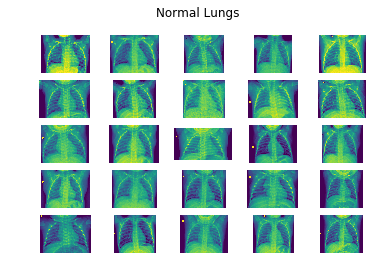

In [5]:
import random
import os
import matplotlib.pyplot as plt
normal_img = os.listdir('../input/chest_xray/chest_xray/train/NORMAL/')
random = random.sample(normal_img,25)
f,ax = plt.subplots(5,5)

for i in range(0,25):
    im = plt.imread('../input/chest_xray/chest_xray/train/NORMAL/'+random[i])
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
f.suptitle('Normal Lungs')
plt.show()

In [6]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential

base_model=MobileNet( weights='imagenet',include_top=False,input_shape=(224,224,3)) #imports the mobilenet model and discards the last 1000 neuron layer.

Instructions for updating:
Colocations handled automatically by placer.
17227776/17225924 [==============================] - 1s 0us/step


In [7]:

x=base_model.output
x=GlobalAveragePooling2D()(x)

x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3

preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [8]:
model=Model(inputs=base_model.input,outputs=preds)
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [9]:
from keras.optimizers import Adam
from keras.callbacks import  EarlyStopping
Adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
es = EarlyStopping(patience=5)
Adam

In [10]:
model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

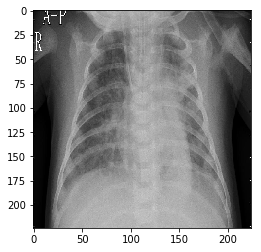

(1, 224, 224, 3)


In [11]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_test=test_generator.n//test_generator.batch_size
#viszualization

img_path='../input/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'
img = image.load_img(img_path,target_size=(224,224))


img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)


In [12]:
history=model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,
                            validation_data=test_generator,validation_steps=step_size_test,callbacks=[es],epochs=15)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
173/173 [==============================] - 89s 515ms/step - loss: 0.1018 - acc: 0.9618 - val_loss: 1.7111 - val_acc: 0.6767
Epoch 2/15
173/173 [==============================] - 73s 420ms/step - loss: 0.0272 - acc: 0.9894 - val_loss: 2.0660 - val_acc: 0.6498
Epoch 3/15
173/173 [==============================] - 75s 432ms/step - loss: 0.0128 - acc: 0.9953 - val_loss: 2.9536 - val_acc: 0.6481
Epoch 4/15
173/173 [==============================] - 73s 422ms/step - loss: 0.0145 - acc: 0.9944 - val_loss: 2.6760 - val_acc: 0.6481
Epoch 5/15
173/173 [==============================] - 73s 420ms/step - loss: 0.0101 - acc: 0.9961 - val_loss: 1.1929 - val_acc: 0.7710
Epoch 6/15
173/173 [==============================] - 73s 419ms/step - loss: 0.0032 - acc: 0.9988 - val_loss: 5.0931 - val_acc: 0.6178
Epoch 7/15
173/173 [==============================] - 72s 417ms/step - loss: 0.0064 - acc: 0.9975 - val_loss: 0.9138 - val_acc: 0.8266
Epoch 8

In [13]:
#val accuracy
score  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 7s 323ms/step
Test loss: 4.085257284916365
Test accuracy: 0.6426282141071099


In [14]:
predgen = model.predict_generator(test_generator, steps=len(test_generator), verbose=1) 
pred = np.argmax(predgen,axis = 1)
y_true=test_generator.classes

21/21 [==============================] - 7s 350ms/step


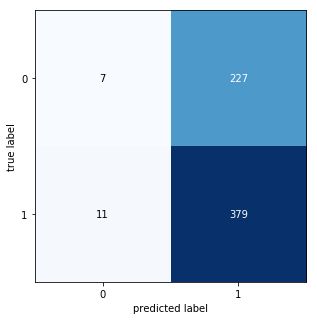

In [15]:
#confution matrix

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [16]:
# Calculate Precision and Recall
tn, fp, fn, tp = CM.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.97
Precision of the model is 0.63


**Classifier Results:**                       
99% **accuracy** on train data.                 
97% **Recall** acheived by the model.